# PyPHS Tutorial 3: The electro-mechanical piano

* Add ports to `Graph` objects
* Connect several PyPHS `Core` objects

<img src="files/figures/systems2.png">


#### Outline
1. Oscillator
2. Pickup
3. Lowpass filter
4. Interconnection

### Additionnally
* Simulation

## 1. Oscillator
Oscillator graph: 
* 2 storages (Mass, Stiffness)
* 1 dissipation (Damper)
* 1 port ($u$=force, $y$=velocity) 

In [1]:
from pyphs.dictionary import mechanics 

label = 'OscMass'
nodes = ('OscMass', )
osc_graph = mechanics.Mass(label=label, nodes=nodes, M=('OscM', 0.1))

label = 'OscStiff'
nodes = ('#', 'OscMass')
osc_graph += mechanics.Stiffness(label=label, nodes=nodes, K=('OscK', 5e6))

label = 'OscDamp'
nodes = ('#', 'OscMass')
osc_graph += mechanics.Damper(label=label, nodes=nodes, A=('OscA', 1))

label = 'OscPort'
nodes = ('#', 'OscMass')
osc_graph += mechanics.Source(label=label, nodes=nodes, type='force')

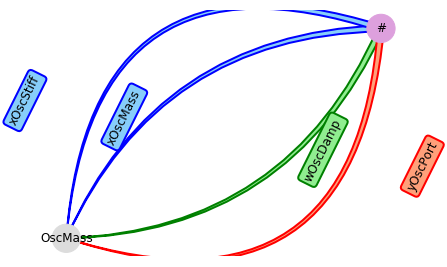

In [2]:
osc_graph.plot()

In [3]:
osc_core = osc_graph.to_core()
osc_core.reduce_z()
osc_core.pprint()

⎡⎡dxOscStiff⎤  ⎡ 0       1.0      0  ⎤  ⎡gxOscStiff⎤⎤
⎢⎢          ⎥  ⎢                     ⎥  ⎢          ⎥⎥
⎢⎢dxOscMass ⎥, ⎢-1.0  -1.0⋅OscA  -1.0⎥, ⎢gxOscMass ⎥⎥
⎢⎢          ⎥  ⎢                     ⎥  ⎢          ⎥⎥
⎣⎣ yOscPort ⎦  ⎣ 0       1.0      0  ⎦  ⎣ uOscPort ⎦⎦


## 2. Pickup
* Pickup component: `pyphs.dictionary.transducers.Pickup`
* 2 ports: 
    * Electronic ($u$=voltage, $y$=current) 
    * Mechanic ($u$=velocity, $y$=force)
* Details:
[Antoine Falaize and Thomas Hélie. Passive simulation of the nonlinear port-hamiltonian modeling of a rhodes piano. Journal of Sound and Vibration, 2016.](https://afalaize.github.io/publis/P2.pdf)
    

In [4]:
from pyphs.dictionary.transducers import Pickup
from pyphs.dictionary import electronics


nodes = ('PckMeca', 'PckElec', '#')
label = 'pck'
args = {'Ccoil': 330e-7,    # Pickup coil inductance (H)
        'Ncoil': 1.,        # Number of wire turns (d.u)
        'Rb': 2e-3,         # material radius (m)
        'Rp': 1e-2,         # pickup radius (m)
        'H0': 1.,           # Magnet mmf (A)
        'Lh': 1e-2,         # horizontal decay (m) 
        'Lv': 1e-2}         # vertical decay (m)

pck_graph = Pickup(label=label, nodes=nodes, **args)

label = 'PckPortElec'
nodes = ('#', 'PckElec')
pck_graph += electronics.Source(label=label, nodes=nodes, type='voltage')

label = 'PckPortMeca'
nodes = ('#', 'PckMeca')
pck_graph += mechanics.Source(label=label, nodes=nodes, type='velocity')

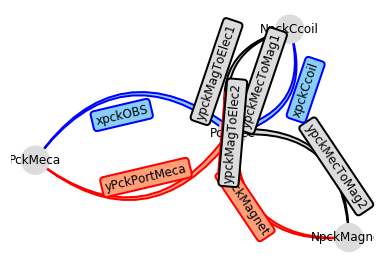

In [5]:
pck_graph.plot()

In [6]:
pck_core = pck_graph.to_core()
pck_core.reduce_z()
pck_core.pprint()

⎡                ⎡ 0       0       0    1.0     0    ⎤                ⎤
⎢                ⎢                                   ⎥                ⎥
⎢                ⎢                1.0         -1.0   ⎥                ⎥
⎢⎡  dxpckOBS  ⎤  ⎢ 0       0      ────   0   ────────⎥  ⎡  gxpckOBS  ⎤⎥
⎢⎢            ⎥  ⎢                pckf       pckNcoil⎥  ⎢            ⎥⎥
⎢⎢ dxpckCcoil ⎥  ⎢                                   ⎥  ⎢ gxpckCcoil ⎥⎥
⎢⎢            ⎥  ⎢       -1.0                        ⎥  ⎢            ⎥⎥
⎢⎢ ypckMagnet ⎥, ⎢ 0     ─────     0     0      0    ⎥, ⎢ upckMagnet ⎥⎥
⎢⎢            ⎥  ⎢        pckf                       ⎥  ⎢            ⎥⎥
⎢⎢yPckPortMeca⎥  ⎢                                   ⎥  ⎢uPckPortMeca⎥⎥
⎢⎢            ⎥  ⎢-1.0     0       0     0      0    ⎥  ⎢            ⎥⎥
⎢⎣yPckPortElec⎦  ⎢                                   ⎥  ⎣uPckPortElec⎦⎥
⎢                ⎢        1.0                        ⎥                ⎥
⎢                ⎢ 0    ────────   0     0      0    ⎥          

## 3. Lowpass
* 1 storage: Capacitor $C$
* 2 dissipations: Resistances $R_1$ and $R_2$
* 2 ports: 
    * Input ($u$=current, $y$=voltage) 
    * Output ($u$=current, $y$=voltage)

In [7]:
label = 'LpIn'
nodes = ('LpIn', '#')
lp_graph = electronics.Source(label=label, nodes=nodes, type='current')

label = 'LpOut'
nodes = ('LpOut', '#')
lp_graph += electronics.Source(label=label, nodes=nodes, type='current')

label = 'LpC'
nodes = ('LpOut', '#')
lp_graph += electronics.Capacitor(label=label, nodes=nodes, C=('LpC', 1e-6))

label = 'LpR1'
nodes = ('LpIn', 'LpOut')
lp_graph += electronics.Resistor(label=label, nodes=nodes, R=('LpR1', 1e3))

label = 'LpR2'
nodes = ('LpOut', '#')
lp_graph += electronics.Resistor(label=label, nodes=nodes, R=('LpR2', 1e3))

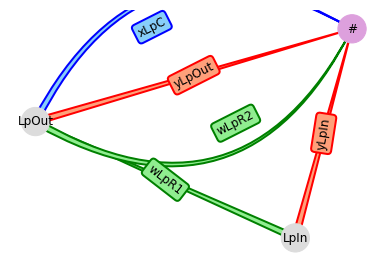

In [8]:
lp_graph.plot()

In [9]:
lp_core = lp_graph.to_core()
lp_core.reduce_z()
lp_core.pprint()

⎡          ⎡-1.0                  ⎤          ⎤
⎢⎡dxLpC ⎤  ⎢─────  -1.0    -1.0   ⎥  ⎡gxLpC ⎤⎥
⎢⎢      ⎥  ⎢ LpR₂                 ⎥  ⎢      ⎥⎥
⎢⎢yLpOut⎥, ⎢                      ⎥, ⎢uLpOut⎥⎥
⎢⎢      ⎥  ⎢ 1.0    0        0    ⎥  ⎢      ⎥⎥
⎢⎣yLpIn ⎦  ⎢                      ⎥  ⎣uLpIn ⎦⎥
⎣          ⎣ 1.0    0    -1.0⋅LpR₁⎦          ⎦


## 4. Interconnection

1. Concatenate `Core` objects: `core = core1 + core2`
2. Define interconnections: `Core.add_connector`
3. Apply interconnections: `Core.connect`

### 4.1. Concatenate `Core` objects: `core = core1 + core2`

In [10]:
from pyphs import Core
core = Core('pianoem')  # Init main Core

In [11]:
core += pck_core        # Add pickup core
core += osc_core        # Add oscillator core
core += lp_core         # Add lowpass core

### 4.2. Define interconnections: `Core.add_connector`

In [12]:
core.u                             # get inputs ordering

Connection (here $\alpha=1$):
* $uPckPortMeca = \alpha \, yOscPort$
* $uOscPort = -\alpha \, yPckPortMeca$

In [13]:
# core.u[1] = alpha * core.y[3]
# core.u[3] = -alpha * core.y[1]
indices = (1, 3)
alpha = 1
core.add_connector(indices, alpha)

In [14]:
core.u                             # get inputs ordering

Connection (here $\alpha=1$):
* $uPckPortElec = \alpha \, yLpIn$
* $uLpIn = -\alpha \, yPckPortElec$

In [15]:
# core.u[1] = alpha * core.y[3]
# core.u[3] = -alpha * core.y[1]
indices = (1, 3)
alpha = 1
core.add_connector(indices, alpha)

### 4.3. Apply interconnections: `Core.connect`

In [16]:
core.connect()
core.pprint()

⎡              ⎡ 0                                 0                          
⎢              ⎢                                                              
⎢              ⎢                               -1.0⋅LpR₁                      
⎢              ⎢ 0          ───────────────────────────────────────────────   
⎢              ⎢                                      ⎛            2      ⎞   
⎢              ⎢                    2 ⎛        2    ⎞ ⎜    1.0⋅LpR₁       ⎟   
⎢              ⎢            pckNcoil ⋅⎝1.0⋅LpR₁  + 1⎠⋅⎜- ───────────── + 1⎟   
⎢              ⎢                                      ⎜          2        ⎟   
⎢              ⎢                                      ⎝  1.0⋅LpR₁  + 1    ⎠   
⎢⎡ dxpckOBS ⎤  ⎢                                                              
⎢⎢          ⎥  ⎢ 0                                 0                          
⎢⎢dxpckCcoil⎥  ⎢                                                              
⎢⎢          ⎥  ⎢1.0                                0

## Additionnally: Simulation

In [17]:
import os
label = 'pianoem'
config = {'fs': 48e3,                                # sample rate (Hz)
          'path': os.path.join(os.getcwd(), label),  # folder for output results
         }
T = 2.                                               # simulation time (s)
nt = int(T*config['fs'])                             # number of time steps (int)

In [18]:
core.x                                       # get state ordering

In [19]:
inits = {'x': [0., 0., 0., 1., 0.]}                  # initial values
simu = core.to_simulation(config=config, inits=inits) # `Simulation` object.

In [20]:
simu.method.u                            # get inputs ordering

In [21]:
def u():
    """
    Generator of nt constants (fmm, 0)
    """
    fmm = 10.
    for _ in range(nt):
        yield (fmm, 0)

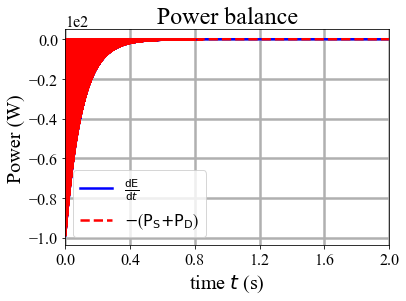

In [22]:
simu.init(u=u(), nt=nt)         # initialize `Data` object
simu.process()                  # process
simu.data.plot_powerbal()

In [23]:
vector = 'y'         # in ['x', 'dx', 'dxH', 'w', 'z', 'u', 'y']
index = 1            # index in chosen vector

# wav file path without '.wav' extension
path = os.path.join(simu.config['path'], label+'_out') 
simu.data.wavwrite(vector, index, 
                   path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto3_pianoem/pianoem/pianoem_out
Convert generator to list...
Fade begining and ending...
Write wave file...
